# Inference using a two compartment error model incorporating constant and multiplicative errors

This example shows you how to perform Bayesian inference on a time-series problem with a constant and multiplicative Gaussian error, using [Haario's Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html).

A constant and multiplicative Gaussian error is a Gaussian error whose standard deviation receives a constant contribution $\sigma _{\text{base}}$, and a contribution $\sigma _{\text{rel}}$ that scales with the model output. In other words, for a model $f(t; \theta)$ its constant and multiplicative Gaussian error is

\begin{equation*}
    \varepsilon = \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

where $\eta $ is some constant that controls the relative scaling behaviour of the error. $\varepsilon _n$ is a standard Gaussian random variable, $\varepsilon _n\sim \mathcal{N}(0, 1)$. A constant and multiplicative Gaussian error model for inference may be implemented using [`pints.ConstantAndMultiplicativeGaussianLogLikelihood`](https://pints.readthedocs.io/en/latest/log_likelihoods.html#pints.ConstantAndMultiplicativeGaussianLogLikelihood).

As a toy time-series we consider a logistic growth

\begin{equation*}
    f(t; \theta) = \frac{k}{1 + (k / f_0 - 1) e^{-r t}},
\end{equation*}

where $\theta = (f_0, r, k)$. Here $f_0$ is the initial population size $f(t=0, \theta) = f_0$, $r$ is the growth rate, and $k$ is the carrying capacity. A logistic growth model with a constant and multiplicative Gaussian error

\begin{equation*}
    y(t; \theta, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = f(t; \theta)f(t, \theta) + \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

has thus 6 model parameters which we may want to learn from data.

## Generating data

To illustrate how Bayesian inference may be used to learn the parameters of a logistic growth model with a constant and multiplicative Gaussian error, let us generate some data for a fixed set of model parameters

\begin{equation*}
    (f_0, r, k, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = (2, 0.015, 500, 10, 1.1, 0.05).
\end{equation*}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot
import pints.toy

# Define model parameters
parameters = [2, 0.015, 500, 10, 1.1, 0.05]
f_0, r, k, sigma_base, eta, sigma_rel = parameters

# Instantiate logistic growth model with f(t=0) = f_0
model = pints.toy.LogisticModel(initial_population_size=f_0)

# Define measurement time points
times = np.linspace(start=0, stop=1000, num=50)

# Solve logistic growth model
model_output = model.simulate(parameters=[r, k], times=times)

# Add noise to the model output according to the combined Gaussian error model
# Draw a standard Gaussian random variable for each model output
gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))

# Scale standard Gaussian noise according to error model
error = (sigma_base + sigma_rel * model_output**eta) * gauss

# Add noise to model output
observations = model_output + error

# Save data as time-observation tuples
data = np.vstack([times, observations])

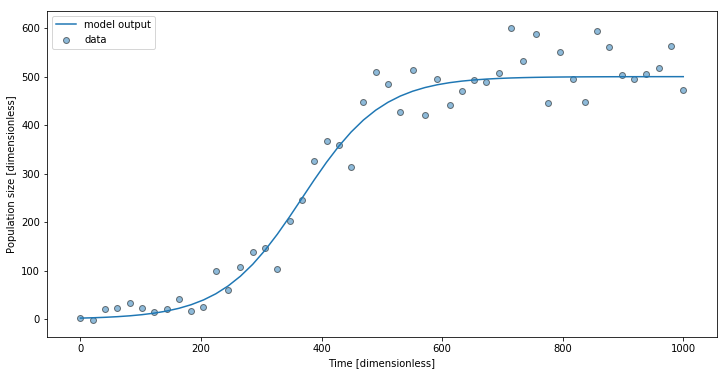

In [2]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot model output (no noise)
plt.plot(data[0, :], model_output, label='model output')

# Plot generated data
plt.scatter(data[0, :], data[1, :], label='data', edgecolors='black', alpha=0.5)

# Create X and Y axis title
plt.xlabel('Time [dimensionless]')
plt.ylabel('Population size [dimensionless]')

# Create legend
plt.legend()

# Show figure
plt.show()

## Inference of model parameters

We now try to recover the model parameters using pints' implementation of Haario's Adaptive Covariance MCMC, [`pints.HaarioACMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html).

In order to do that we need to construct a [`pints.LogPosterior`](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPosterior) that incorporates the above simulated data, the logistic growth model and the error model. For a detailed introduction to how to do this in [pints](https://pints.readthedocs.io/en/latest/), please have a look at the dedicated [notebooks](https://github.com/pints-team/pints/blob/main/examples/sampling/first-example.ipynb).

Let us simplify the inference by fixing the initial population size $f_0$ and the carrying capacity $k$ to the true values.

### Create posterior

We now implement the posterior we will sample from by wrapping the Logistic Growth model in a `pints.ForwardModel`, defining a `pints.ConstantAndMultplicativeGaussianLogLikelihood` and `pints.UniformLogPrior`s for the model parameters.

In [3]:
# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)

    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)

    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the constant and multiplicative Gaussian error log-likelihood
log_likelihood = pints.ConstantAndMultiplicativeGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### Infer parameters with Haario Adaptive Covariance MCMC

In [4]:
# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
hacmc_chains = mcmc.run()
print('Done!')

Running...
Done!


## Show quantitative and visual diagnostics of MCMC runs

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1562.61  117.24
sigma_base  14.06   3.02    8.75    11.71  13.96  16.48  19.50    1.00    639.67   47.99
eta         0.70    0.11    0.55    0.62   0.67   0.74   1.02     1.02    109.75   8.23
sigma_rel   0.58    0.26    0.07    0.37   0.60   0.79   0.98     1.01    223.76   16.79


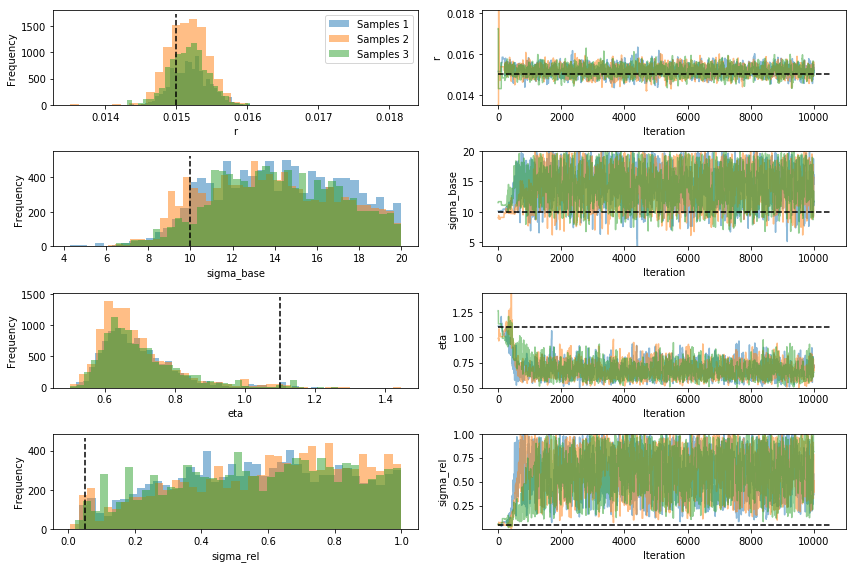

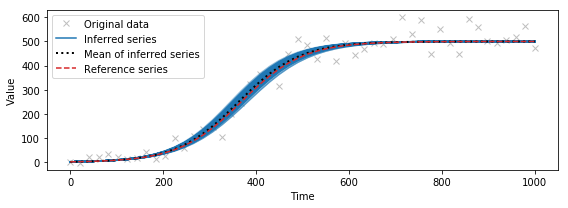

In [5]:
# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

# Show predicted time series for the first chain
pints.plot.series(hacmc_chains[0, 200:], problem, true_parameters)
plt.show()

We can see that although all three MCMC runs behave very similarly ($\hat R$ close to 1, and the sampled posteriors almost entirely lie on top of each other), the sampled posteriors largely fail to recover the true model parameters. While AMCMC was able to infer the  growth rate $r$ quite well, the noise posteriors are unlikely to reproduce the data generating parameter values. It is further worth noticing that the effective sample size (ESS) is significantly smaller for all noise parameters in comparison to $r$.

## Fix noise parameter $\eta $ to improve inference

It appears as if the data is not rich enough to infer all 3 noise parameters $(\sigma _{\text{base}}, \eta, \sigma _{\text{rel}})$. Let us therefore fix $\eta $ at the data generating value and run the inference again.

### Define log-posterior class that allows to fix $\eta $

In [6]:
class LogPosteriorWrapper(pints.LogPDF):
    def __init__(self, log_pdf, eta):
        self._log_pdf = log_pdf
        self._eta = eta

    def __call__(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+1)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:2] = np.asarray(parameters[:2])
        params[2] = self._eta
        params[3] = parameters[2]

        return self._log_pdf(params)

    def n_parameters(self):
        return self._log_pdf.n_parameters() - 1


### Create log-posterior with fixed $\eta $

In [7]:
# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)

    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)

    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the constant and multiplicative Gaussian error log-likelihood
log_likelihood = pints.ConstantAndMultiplicativeGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior (free eta)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Fix eta
eta = true_parameters[2]
log_posterior_fixed_eta = LogPosteriorWrapper(log_posterior, eta)

### Infer parameters with Haario Adaptive Covariance MCMC

In [8]:
# Extract unfixed parameters from true parameters
true_parameters_fixed_eta = np.empty(shape=len(true_parameters)-1)
true_parameters_fixed_eta[0:2] = true_parameters[0:2]
true_parameters_fixed_eta[2] = true_parameters[3]

# Choose starting points for mcmc chains
xs = [
    true_parameters_fixed_eta * 1.01,
    true_parameters_fixed_eta * 0.9,
    true_parameters_fixed_eta * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior_fixed_eta, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
hacmc_chains_fixed_eta = mcmc.run()
print('Done!')

Running...
Done!


## Show quantitative and visual diagnostics of MCMC runs

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1999.25  153.68
sigma_base  16.26   2.38    10.84   14.68  16.51  18.17  19.80    1.01    472.23   36.30
sigma_rel   0.04    0.01    0.03    0.04   0.04   0.05   0.06     1.00    1466.46  112.73


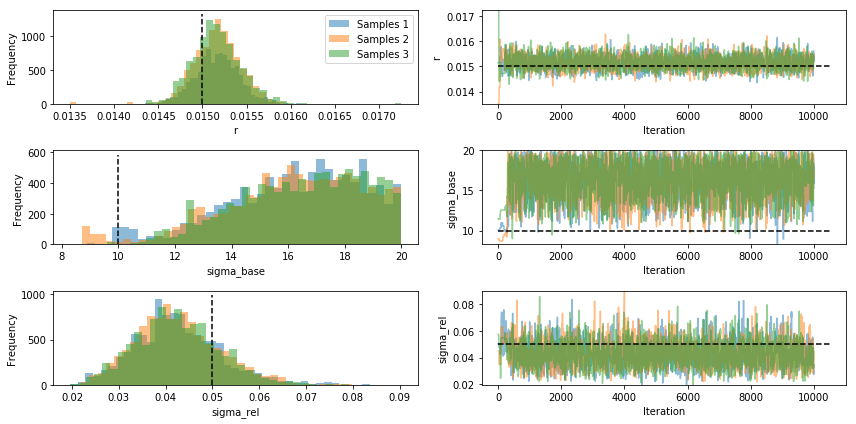

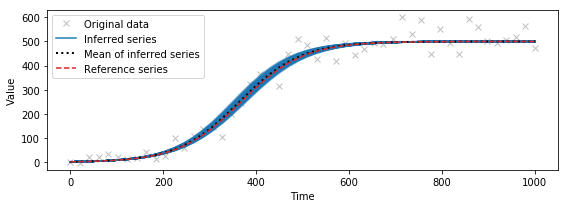

In [9]:
# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains_fixed_eta, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains_fixed_eta, parameter_names=['r', 'sigma_base', 'sigma_rel'], ref_parameters=true_parameters_fixed_eta)
plt.show()

# Show predicted time series for the first chain
pints.plot.series(hacmc_chains_fixed_eta[0, 200:], problem, true_parameters_fixed_eta)
plt.show()